# Trabajo Final - Inteligencia Artificial
## **Nombre:** Eduardo Arce

# Algoritmo del Método:

## 1. Preprocesamiento de los Datos:
- Se realiza una limpieza de los textos para eliminar ruido como caracteres especiales, stop words, etc.
- Se extraen las características de los documentos utilizando un **vectorizador TF-IDF**. Este proceso convierte los textos en vectores numéricos que representan la importancia relativa de las palabras en el corpus.

## 2. Entrenamiento de un Modelo VAE (Variational Autoencoder):
- Se utiliza un **Variational Autoencoder (VAE)** para generar representaciones latentes de los documentos. El VAE permite aprender una distribución de probabilidad sobre el espacio latente.
- Este modelo tiene un **encoder** que transforma los datos de texto a un espacio latente de menor dimensión, permitiendo una representación compacta de los documentos.

## 3. Reducción de Dimensionalidad con PCA:
- Las representaciones latentes generadas por el VAE son sometidas a una **reducción de dimensionalidad utilizando PCA** (Principal Component Analysis).
- PCA reduce la cantidad de variables (características) necesarias para representar los documentos, mientras preserva la información más relevante, facilitando el análisis posterior.

## 4. Agrupación de los Datos con HDBSCAN:
- Usamos el algoritmo **HDBSCAN** (Hierarchical Density-Based Spatial Clustering of Applications with Noise) para agrupar los documentos en diferentes tópicos.
- HDBSCAN agrupa los documentos basándose en la densidad de las representaciones latentes, es decir, los documentos que están más cerca en el espacio latente se agrupan en el mismo tópico, mientras que los más alejados se consideran como ruido.

![Diagrama de flujo](Cap1.png)

- Completado



Importacion de librerias necesarias para la presente implementacion

In [64]:
import fitz  # PyMuPDF
import os
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hdbscan
import re
print("Libraries imported")

# Adicional se descargan recursos de nlkt para tokenizar y lematizar
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
print("NLTK resources downloaded")


Libraries imported
NLTK resources downloaded


[nltk_data] Downloading package punkt to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# FASE 1: PLN
## **Tecnicas Usadas:**

### Limpieza de stopwords y lematizacion:

In [65]:
## Seteamos diferentes stopwords para aislarlos del texto
# 📌 Stopwords personalizadas
stop_words = set(stopwords.words("english")).union({
    "abstract", "sample", "madrid", "introduction", "conclusion", "method", "study", "approach", 
    "paper", "result", "propose", "data", "information", "model", "analysis",
    "table", "figure", "algorithm", "system", "value", "based", "case", "using", "abrahamgutierrez", "abrahamgutierrezupmes"
})

## Lematizamos el texto (es decir, lo transformamos a su raíz, esto mediante un diccionario que tiene la biblioteca)
lemmatizer = WordNetLemmatizer()

## Limpieza de texto
##### **- Convertir a minisculas**
##### **- Eliminar numeros**
##### **- Eliminar signos de puntuacion**
##### **- Tokenizacion**

In [66]:
# 📌 Función de limpieza mejorada
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenización
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatización y stopwords
    return " ".join(tokens)

## Clasificacion de titulos, keywords y body de documentos

In [67]:
# 📌 Extraer textos, títulos y keywords de PDFs
def extract_text_titles_keywords(pdf_path):
    doc = fitz.open(pdf_path)
    full_text, titles, keywords = [], [], []
    found_keywords = False

    for page_num, page in enumerate(doc):
        raw_text = page.get_text("text")
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"].strip()
                        if text:
                            full_text.append(text)
                            if span["size"] > 12:  # Títulos grandes
                                titles.append(text)

        # 📌 Extraer Keywords
        if page_num == 0:
            keywords_match = re.search(r"(?i)(?:Keywords|Palabras Clave|KEYWORDS)[:\s]*(.*)", raw_text)
            if keywords_match:
                extracted_keywords = keywords_match.group(1).strip()
                if len(extracted_keywords) > 2:
                    keywords.append(extracted_keywords)
                    found_keywords = True

    if not found_keywords:
        keywords.append("")  # Evitar NaN en el DataFrame

    return " ".join(full_text), " | ".join(titles), " | ".join(keywords)

## Extraccion de contenido de pdfs y aplicacion de PLN

In [68]:
# 📌 Extraer de todos los PDFs
def extract_text_from_pdfs_in_folder(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(folder_path, filename)
            text, titles, keywords = extract_text_titles_keywords(pdf_path)
            pdf_texts.append({
                "Documento": filename,
                "Titulos_Extraidos": titles,
                "Keywords_Extraidas": keywords,
                "Texto_Original": text
            })
    return pd.DataFrame(pdf_texts)

# 📂 📌 Ruta de PDFs
folder_path = "Documents/Repositorio" 

# 📌 Extraer texto, títulos y keywords
df_pdfs_original = extract_text_from_pdfs_in_folder(folder_path)




### GENERACION DE DATAFRAME CON DATOS ORIGINALES

In [69]:
# GENERACION DE DATAFRAME CON DATOS ORIGINALES
df_pdfs_original.to_csv("textos_originales.csv", index=False)

In [70]:
# 📌 Aplicar limpieza mejorada
df_pdfs_original["Texto_Procesado"] = df_pdfs_original["Texto_Original"].apply(clean_text)
df_pdfs_original["Titulos_Procesados"] = df_pdfs_original["Titulos_Extraidos"].apply(clean_text)
df_pdfs_original["Keywords_Procesadas"] = df_pdfs_original["Keywords_Extraidas"].apply(clean_text)

### Breve analisis exploratorio inicial para realizar una exploracion de la data, y asi implementar las mejores soluciones para un correcto manejo de la data


📌 Estadísticas Generales:
       Longitud_Texto  Longitud_Titulo  Longitud_Keywords
count        6.000000         6.000000           6.000000
mean     12776.166667        13.833333           6.833333
std       6490.129596         9.474527           5.706721
min       6466.000000         6.000000           1.000000
25%       8320.250000         9.250000           2.000000
50%      11119.500000        10.000000           6.500000
75%      15196.750000        14.500000          11.750000
max      24009.000000        32.000000          13.000000


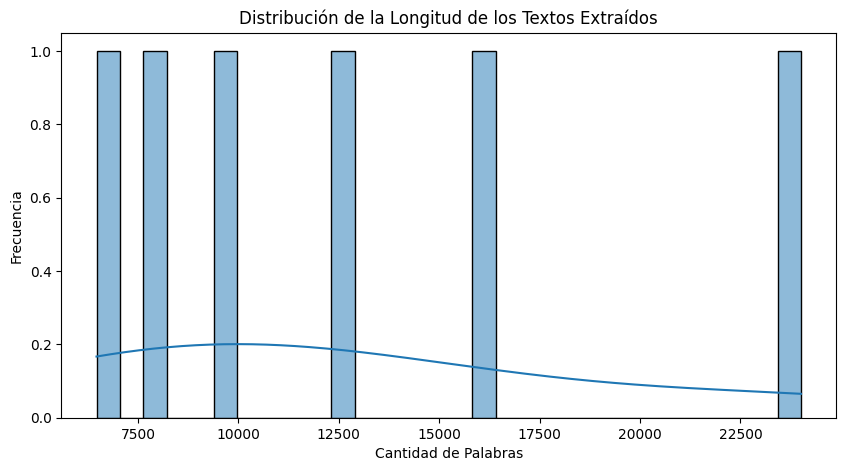

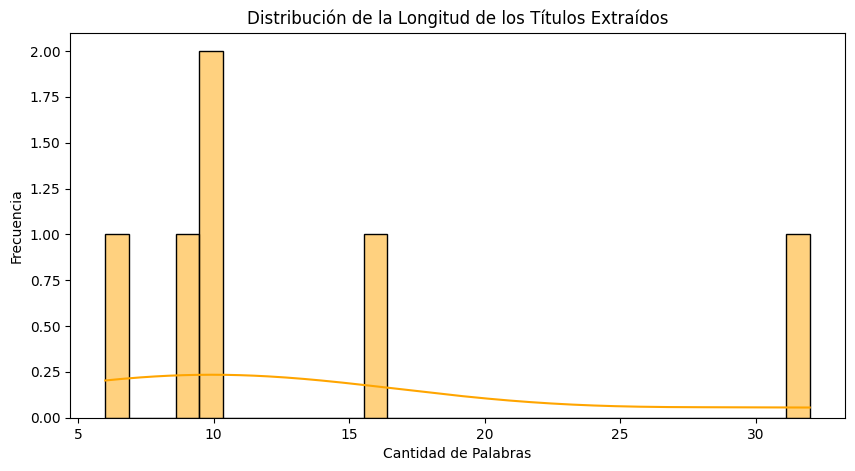

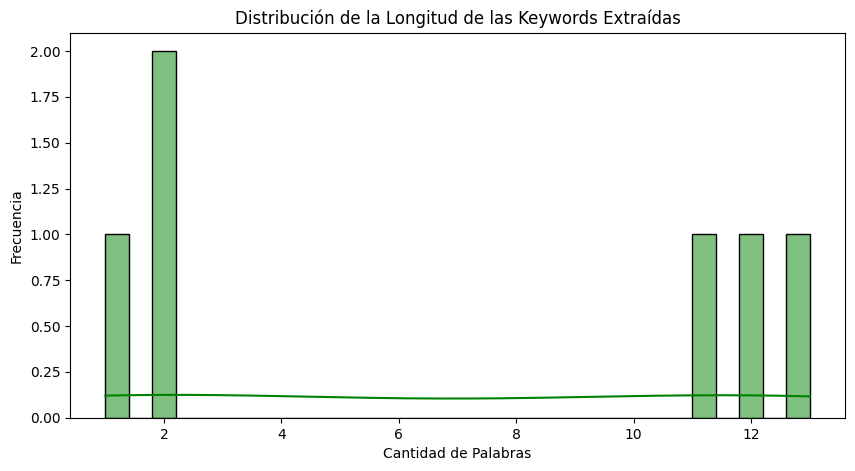

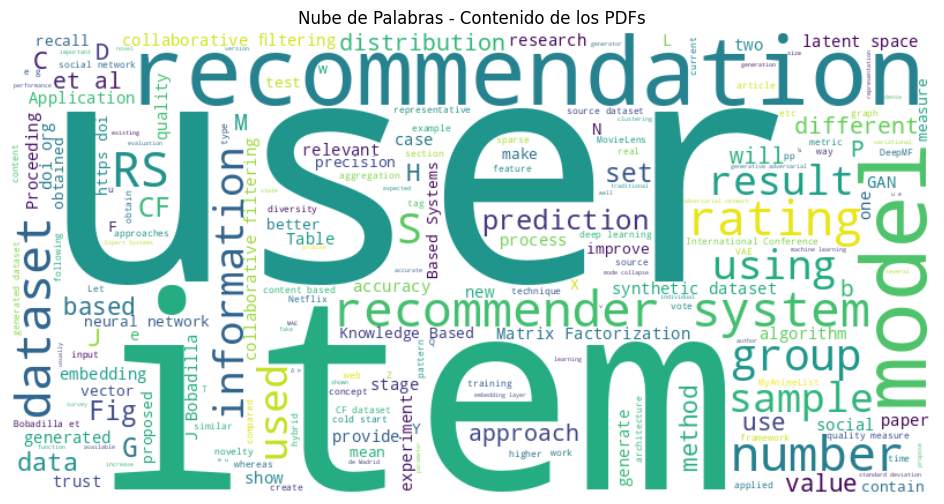

[nltk_data] Downloading package punkt to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📌 Palabras Más Comunes:
   Palabra  Frecuencia
0        ,        5548
1      the        4884
2        .        3725
3        )        2523
4        (        2482
5       of        2256
6      and        1707
7       to        1486
8       in        1421
9        a        1232
10       [         937
11       ]         935
12      is         783
13       :         759
14     for         549
15      on         523
16   users         484
17    that         453
18      as         434
19     are         428


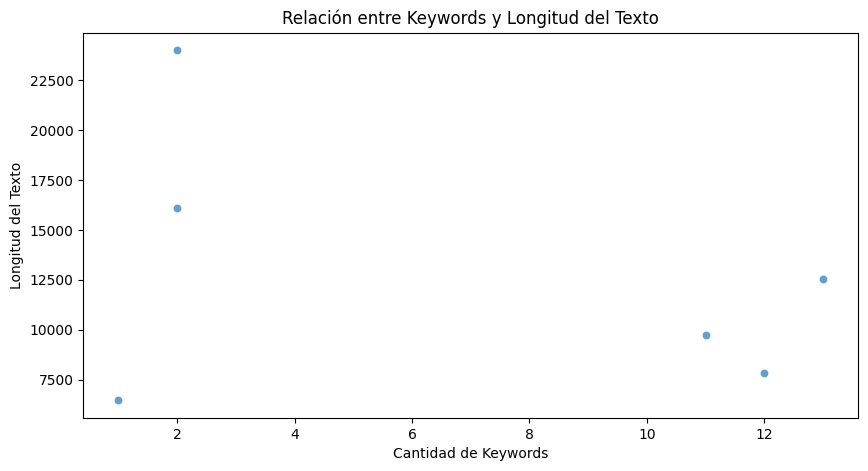

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

# 📌 1️⃣ Cargar el DataFrame con los datos originales
df_pdfs = pd.read_csv("textos_originales.csv")

# 📌 2️⃣ Análisis general de los documentos
df_pdfs["Longitud_Texto"] = df_pdfs["Texto_Original"].apply(lambda x: len(str(x).split()))
df_pdfs["Longitud_Titulo"] = df_pdfs["Titulos_Extraidos"].apply(lambda x: len(str(x).split()))
df_pdfs["Longitud_Keywords"] = df_pdfs["Keywords_Extraidas"].apply(lambda x: len(str(x).split()))

# 📌 3️⃣ Mostrar estadísticos básicos
print("\n📌 Estadísticas Generales:")
print(df_pdfs.describe())

# 📌 4️⃣ Distribución de longitud de textos
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Texto"], bins=30, kde=True)
plt.title("Distribución de la Longitud de los Textos Extraídos")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 5️⃣ Distribución de longitud de títulos
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Titulo"], bins=30, kde=True, color="orange")
plt.title("Distribución de la Longitud de los Títulos Extraídos")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 6️⃣ Distribución de longitud de keywords
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Keywords"], bins=30, kde=True, color="green")
plt.title("Distribución de la Longitud de las Keywords Extraídas")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 7️⃣ Nube de Palabras de los textos completos
text_data = " ".join(df_pdfs["Texto_Original"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras - Contenido de los PDFs")
plt.show()

# 📌 8️⃣ Palabras más comunes en los textos
nltk.download("punkt")
all_words = word_tokenize(text_data.lower())
word_counts = Counter(all_words)

common_words = pd.DataFrame(word_counts.most_common(20), columns=["Palabra", "Frecuencia"])
print("\n📌 Palabras Más Comunes:")
print(common_words)

# 📌 9️⃣ Relación entre cantidad de keywords y longitud del texto
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_pdfs["Longitud_Keywords"], y=df_pdfs["Longitud_Texto"], alpha=0.7)
plt.xlabel("Cantidad de Keywords")
plt.ylabel("Longitud del Texto")
plt.title("Relación entre Keywords y Longitud del Texto")
plt.show()


## Asignacion de orden de importancia a estructura de documentos


In [72]:
# 📌 🔥 **DAR MÁS PESO A TÍTULOS Y KEYWORDS**
df_pdfs_original["Texto_Final"] = (
    (df_pdfs_original["Titulos_Procesados"] + " ") * 3 +  # 🔥 Títulos tienen 3X peso
    (df_pdfs_original["Keywords_Procesadas"] + " ") * 2 +  # 🔥 Keywords tienen 2X peso
    df_pdfs_original["Texto_Procesado"]  # Texto normal
)

# 📌 Guardar DataFrames
df_pdfs_original.to_csv("textos_procesados_con_pesos.csv", index=False)

## Vectorizacion y conversion a dataframe de los datos
#### Usamos TF-IDF para vectorizar, esto consiste basicamente en transformar los datos de texto a numericos

In [73]:
# 📌 TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=7000, stop_words="english", ngram_range=(2, 5), min_df=1, max_df=0.3)
X_tfidf = vectorizer.fit_transform(df_pdfs_original["Texto_Final"]).toarray()

# 📌 Guardar TF-IDF en CSV
pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out()).to_csv("tfidf_vectors_pesados.csv", index=False)

df_tfidf = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out())

print("\n✅ Vista previa del TF-IDF DataFrame:")
print(df_tfidf.head())  # Imprime las primeras 5 filas



✅ Vista previa del TF-IDF DataFrame:
   aa alzahrani  aa alzahrani martínez  aaai press  able create  able make  \
0      0.000000               0.000000         0.0     0.000000   0.000000   
1      0.000000               0.000000         0.0     0.000000   0.000000   
2      0.000000               0.000000         0.0     0.000000   0.015889   
3      0.026394               0.026394         0.0     0.026394   0.000000   
4      0.000000               0.000000         0.0     0.000000   0.000000   

   accomplish task  according distance  according number  \
0          0.00000            0.000000           0.00000   
1          0.00000            0.000000           0.00000   
2          0.00000            0.015889           0.00000   
3          0.03959            0.000000           0.03959   
4          0.00000            0.000000           0.00000   

   according number casted  according number casted rating  ...  \
0                  0.00000                         0.00000  ...  

# Fase 2: Topic Modeling

### Normalizacion de la data
#### Esto para el funcionamiento optimo de nuestra red neuronal

In [74]:
# 📌 1️⃣ Cargar el DataFrame con los textos procesados
df = pd.read_csv("textos_procesados_con_pesos.csv")


# 📌 2️⃣ Dar más peso a títulos y keywords
df["Texto_Final"] = df.apply(
    lambda row: f"{' '.join([str(row['Titulos_Procesados'])]*3)} "
                f"{' '.join([str(row['Keywords_Procesadas'])]*2)} "
                f"{str(row['Texto_Procesado'])}",
    axis=1
)

# 📌 3️⃣ Vectorización TF-IDF con frases clave
#vectorizer = TfidfVectorizer(max_features=3000, stop_words="english", ngram_range=(1, 5), min_df=2, max_df=0.85)

X_tfidf = vectorizer.fit_transform(df["Texto_Final"]).toarray()

# 📌 4️⃣ Escalar los embeddings TF-IDF
scaler = MinMaxScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf)
print("\n✅ Embeddings TF-IDF escalados:")
print(X_tfidf_scaled)


✅ Embeddings TF-IDF escalados:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Estructura de la red neuronal variacional (VAE)
### Configuramos la capa de entrada y los encoders para reducir la dimensionalidad de los datos

In [75]:
# Definimos la dimesion latente (comprimira la entrada en solo 20 dimensiones)
latent_dim = 35  
# Capa de entrada
input_layer = keras.Input(shape=(X_tfidf_scaled.shape[1],))
#Creamos el encoder con 3 capas densas
encoder = layers.Dense(512, activation="relu")(input_layer)
# Agregamos BatchNormalization para normalizar los valores de las capas
encoder = layers.BatchNormalization()(encoder)
# Agregamos Dropout para evitar overfitting
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(256, activation="relu")(encoder)
encoder = layers.BatchNormalization()(encoder)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(128, activation="relu")(encoder)

encoder = layers.Dense(64, activation="tanh")(encoder)

### Se definen 2 capas, que modelan la distribucion gaussiana del espacio latente

In [76]:
# Se definen 2 capas, que modelan la distribucion gaussiana del espacio latente
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)

### Capa personalizada para reparametrizacion de muestreo en el VAE
#### Formula: z=μ+σ⋅ϵ

In [77]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

### Decodificador del VAE (Reconstruye los datos originales)

In [78]:
decoder = layers.Dense(512, activation="relu")(z)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.Dropout(0.2)(decoder)
decoder = layers.Dense(256, activation="relu")(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.Dropout(0.2)(decoder)
decoder = layers.Dense(128, activation="relu")(decoder)
decoder = layers.Dense(X_tfidf_scaled.shape[1], activation="sigmoid")(decoder)

vae = keras.Model(input_layer, decoder)

### Definimos la funcion de perdida (MSE) y entrenamiento
#### Formula usada: KL=−21​i=1∑n​(1+log(σ2)−μ2−σ2)

In [79]:
reconstruction_loss = tf.keras.losses.mean_squared_error(input_layer, decoder)
reconstruction_loss *= X_tfidf_scaled.shape[1]
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

# 📌 7️⃣ Entrenar el modelo VAE
print("\n🚀 Entrenando el VAE con más capacidad y regularización...")
vae.fit(X_tfidf_scaled, X_tfidf_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


🚀 Entrenando el VAE con más capacidad y regularización...


### Extraccion de embeddings latentes del VAE (salida de nuestra red neuronal)

In [80]:
# 📌 8️⃣ Extraer embeddings latentes
encoder_model = keras.Model(input_layer, z_mean)
embeddings_latentes = encoder_model.predict(X_tfidf_scaled)
print("\n✅ Embeddings Latentes Generados:")
print(embeddings_latentes)

1/1 [==============================] - 0s 59ms/step

✅ Embeddings Latentes Generados:
[[ 2.4083939e+00 -1.5850930e-01  1.2830315e+00 -1.3627067e+00
   1.9343599e+00  2.2443590e+00  4.3438578e-01  1.7231208e-01
  -2.0020704e-01  2.6379781e+00 -2.0695689e+00  3.3184772e+00
   6.4497077e-01  4.8076841e-01 -1.4655693e+00  1.2888637e+00
   1.9311233e+00 -3.0243295e-01 -2.6277059e-01 -1.1709628e+00
  -2.1733077e+00  2.0685069e-01  2.1154351e+00 -7.9082596e-01
  -1.2725228e+00  1.5194993e+00  2.6299458e+00  2.2480817e+00
   1.3047528e+00  3.9767903e-01 -6.0621023e-01 -6.6135323e-01
  -1.0444472e+00 -1.6955115e+00  3.9274022e-01]
 [-5.1200992e-01  7.8281063e-01 -1.2465941e+00  9.6262807e-01
   7.2316885e-01 -2.3652365e+00 -2.0855613e+00 -1.3742750e+00
   3.6156377e-01 -6.9500041e-01 -8.5586226e-01  1.9764537e+00
  -9.6848774e-01 -7.3306751e-01  6.1701417e-01 -9.6248072e-01
   3.4868522e+00 -1.0350232e+00 -2.5263560e-01 -5.3675807e-01
  -1.2423393e-02 -5.7520849e-01 -4.7666839e-01 -4.8397085e-0

### Aplicamos PCA para reducir la dimensionalidad de los embeddings obtenidos del VAE

In [81]:
# 📌 9️⃣ Aplicar reducción de dimensionalidad con PCA
n_samples = embeddings_latentes.shape[0]
n_features = embeddings_latentes.shape[1]
n_pca_components = min(10, n_samples, n_features)

pca = PCA(n_components=n_pca_components)
embeddings_pca = pca.fit_transform(embeddings_latentes)
print("\n✅ Embeddings Latentes Reducidos con PCA:")
print(embeddings_pca)


✅ Embeddings Latentes Reducidos con PCA:
[[-9.9907106e-01  6.4853563e+00  4.5374250e+00  5.7283580e-01
   4.9529638e-04  2.2318373e-07]
 [ 3.7748606e+00  3.2874734e+00 -5.0071664e+00  1.1959789e+00
  -4.3394111e-02  2.2318379e-07]
 [-9.0032740e+00 -2.6498127e+00 -1.3508478e+00  6.8493128e-01
  -2.7982981e-03  2.2318370e-07]
 [ 4.5664778e+00 -6.3948712e+00  2.6306458e+00  1.1187291e+00
  -1.7428109e-02  2.2318379e-07]
 [ 1.0227270e+00 -3.1371075e-01 -5.8063662e-01 -1.5714480e+00
   4.6404517e-01  2.2318383e-07]
 [ 6.3827878e-01 -4.1443494e-01 -2.2942190e-01 -2.0010262e+00
  -4.0092009e-01  2.2318372e-07]]


### Aplicacion de HDBSCAN para descubrir topicos

In [82]:
# 📌 🔟 Aplicar HDBSCAN primero
# HDBSCAN agrupa datos basándose en densidad
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2, cluster_selection_method='eom', allow_single_cluster=False)


df["Tópico_Descubierto"] = clusterer.fit_predict(embeddings_pca)


### En caso de que HDBSCAN, haya considerado como ruido a uno o mas de nuestros clusters. Ajustamos de N-Topicos con K-Means

In [83]:
# 📌 1️⃣1️⃣ Ajustar el número de tópicos con K-Means si es necesario
num_topics = int(input("Ingrese el número de tópicos deseados: "))
num_detected = len(set(df["Tópico_Descubierto"])) - (1 if -1 in df["Tópico_Descubierto"].values else 0)

if num_detected < num_topics:
    print(f"🔄 Ajustando los tópicos con K-Means para llegar a {num_topics}...")
    kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
    df["Tópico_Descubierto"] = kmeans.fit_predict(embeddings_pca)


🔄 Ajustando los tópicos con K-Means para llegar a 3...


## Obtenemos palabras clave en cada cluster con TF-IDF 

In [84]:
# 📌 1️⃣2️⃣ Obtener frases clave representativas
feature_names = vectorizer.get_feature_names_out()
top_phrases_per_topic = []

for i in range(num_topics):
    cluster_docs = df[df["Tópico_Descubierto"] == i]["Texto_Final"]
    
    if cluster_docs.empty:
        top_phrases_per_topic.append(["Unknown Topic"])
        continue
    
    cluster_tfidf = vectorizer.transform(cluster_docs)
    avg_tfidf = np.mean(cluster_tfidf, axis=0).flatten()
    top_phrase_indices = np.argsort(avg_tfidf.A1)[::-1][:7]
    top_phrases = [feature_names[idx] for idx in top_phrase_indices]
    top_phrases_per_topic.append(list(dict.fromkeys(top_phrases)))  # Eliminar repeticiones


### Filtramos terminos irrelevantes

In [85]:
# 📌 1️⃣3️⃣ Filtrar términos irrelevantes
stop_phrases = {"et al", "pp", "conference", "journal", "vol", "dataset", "recommendation", "user",
                 "et", "al", "bobadilla"}
def clean_topic_name(name):
    words = name.split()
    return " ".join([word for word in words if word.lower() not in stop_phrases])

### Generamos los nombres de topicos

In [86]:
def generate_topic_name(phrases):
    phrases = [clean_topic_name(p).strip() for p in phrases if p.strip()]  # Quita espacios vacíos
    phrases = list(dict.fromkeys(phrases))  # Elimina duplicados
    
    # 📌 ⚠️ Filtrar palabras demasiado generales que pueden estar agregando ruido
    phrases = [p for p in phrases if p.lower() not in stop_phrases]
    
    # 📌 ⚠️ Si hay más de 3 frases, selecciona las más informativas
    if len(phrases) > 3:
        phrases = phrases[:3]  # Limita a 3 términos clave
    
    if len(phrases) >= 3:
        return f"{phrases[0]} and {phrases[1]} in {phrases[2]}"
    elif len(phrases) == 2:
        return f"{phrases[0]} and {phrases[1]}"
    elif len(phrases) == 1:
        return phrases[0]
    else:
        return "Unknown Topic"



topic_labels = [generate_topic_name(phrases) for phrases in top_phrases_per_topic]
# 📌 1️⃣5️⃣ Asignar nombres interpretables a los tópicos
df["Nombre_Topico"] = df["Tópico_Descubierto"].map(lambda x: topic_labels[x])

# 📌 1️⃣6️⃣ Guardar resultados finales
df.to_csv("topicos_mejorados.csv", index=False)

# 📌 🔥 Mostrar resumen
print("\n📌 Cantidad de documentos en cada tópico:")
print(df["Tópico_Descubierto"].value_counts())

print("\n📌 Tópicos detectados con nombres interpretables:")
for i, name in enumerate(topic_labels):
    print(f"Tópico {i+1}: {name}")


📌 Cantidad de documentos en cada tópico:
Tópico_Descubierto
0    4
1    1
2    1
Name: count, dtype: int64

📌 Tópicos detectados con nombres interpretables:
Tópico 1: bnmf urp and proposed wganrs in epoch epoch
Tópico 2: expert application and similarity measure in knowledgebased
Tópico 3: gan generator and mae accuracy in noise gaussian


### Observamos una grafica para observar a que documentos pertenecen los diversos topicos que hemos obtenido

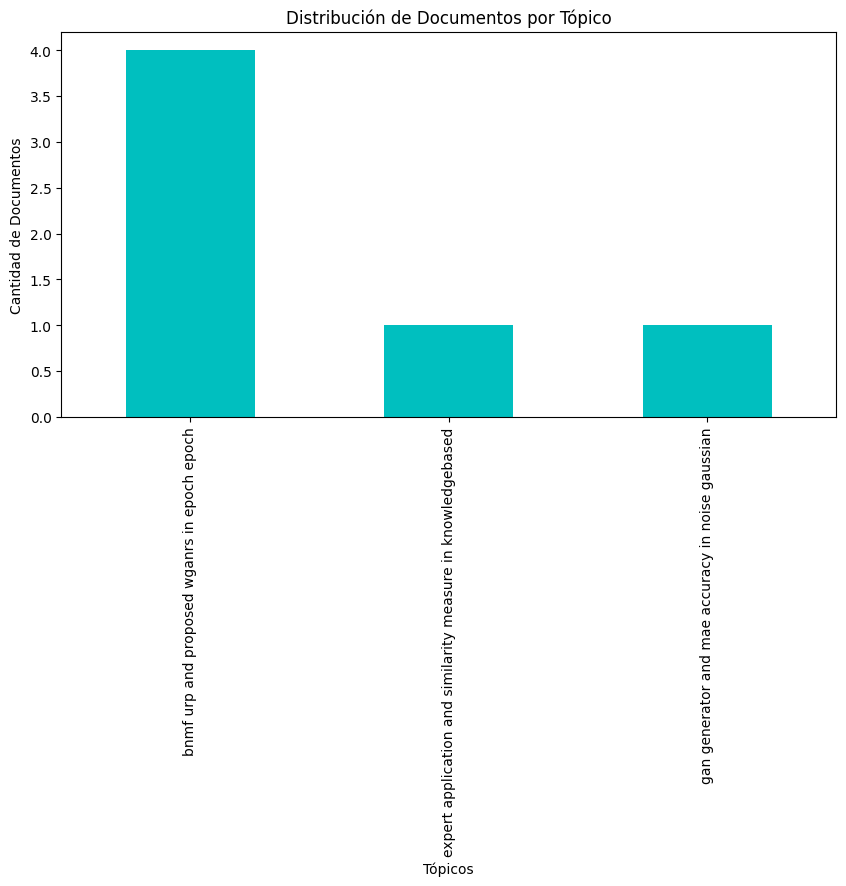

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Cargar datos
df = pd.read_csv("topicos_mejorados.csv")

# 📊 Contar documentos por tópico
topico_counts = df["Nombre_Topico"].value_counts()

# 📊 Graficar distribución de tópicos
plt.figure(figsize=(10, 5))
topico_counts.plot(kind="bar", color="c")
plt.title("Distribución de Documentos por Tópico")
plt.xlabel("Tópicos")
plt.ylabel("Cantidad de Documentos")
plt.xticks(rotation=90)
plt.show()


In [88]:
import importlib
import keyEdu

importlib.reload(keyEdu)  # Fuerza a Python a recargar el módulo

api_key = keyEdu.OPENAI_API
print("xd")
#print(api_key)

xd


### Mejora de topicos, añadiendole mas sentido y semantica con el modelo de OPENAI

In [89]:
import pandas as pd
import numpy as np
import openai
from fpdf import FPDF
from sklearn.feature_extraction.text import TfidfVectorizer

# 📌 1️⃣ Cargar los documentos con sus tópicos
df = pd.read_csv("topicos_mejorados.csv")

# 📌 2️⃣ Seleccionar los documentos más representativos
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X_tfidf = vectorizer.fit_transform(df["Texto_Final"]).toarray()

# Sumar la importancia TF-IDF por documento
df["Importancia"] = np.sum(X_tfidf, axis=1)

# 📌 3️⃣ Seleccionar los documentos más representativos (percentil 75%)
df_top = df.groupby("Nombre_Topico").apply(lambda x: x[x["Importancia"] >= x["Importancia"].quantile(0.5)]).reset_index(drop=True)

# 📌 4️⃣ **Mejorar los nombres de los tópicos usando OpenAI**
def mejorar_topicos(topicos, modelo="gpt-4o"):
    """
    Refinar nombres de tópicos con OpenAI para que sean más claros y representativos.
    """
    client = openai.OpenAI(api_key=api_key)  # Asegúrate de definir tu API Key correctamente
    
    prompt = (f"""Los siguientes nombres de tópicos fueron generados automáticamente a partir de análisis de documentos. 
    Por favor, reformúlalos para que sean más claros, naturales y representativos de su contenido. 

    Tópicos actuales:
    {topicos}

    Devuelve únicamente la lista mejorada de tópicos sin explicaciones, en el mismo orden.
    """)

    response = client.chat.completions.create(
        model=modelo,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=500
    )

    return response.choices[0].message.content.strip().split("\n")  # Retorna lista de nombres mejorados

# Extraemos los nombres de los tópicos actuales y los mejoramos
topicos_actuales = df_top["Nombre_Topico"].unique().tolist()
topicos_mejorados = mejorar_topicos("\n".join(topicos_actuales))

# 📌 5️⃣ **Reemplazar los nombres de los tópicos con las versiones mejoradas**
mapeo_topicos = dict(zip(topicos_actuales, topicos_mejorados))
df_top["Nombre_Topico"] = df_top["Nombre_Topico"].map(mapeo_topicos)
print("\n📌 Tópicos mejorados:")
for i, topico in enumerate(topicos_mejorados, start=1):
    print(f"Tópico {i}: {topico}")





/tmp/ipykernel_6775/4139008122.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby("Nombre_Topico").apply(lambda x: x[x["Importancia"] >= x["Importancia"].quantile(0.5)]).reset_index(drop=True)



📌 Tópicos mejorados:
Tópico 1: - Rendimiento de URP y WGAN-RS en diferentes épocas
Tópico 2: - Aplicaciones expertas y medidas de similitud en sistemas basados en conocimiento
Tópico 3: - Exactitud de MAE y generadores GAN en presencia de ruido gaussiano


## Generacion de resumenes

In [90]:
# 📌 6️⃣ Generar resúmenes para cada **tópico**, no por cada documento
resumenes_topicos = df_top.groupby("Nombre_Topico")["Texto_Final"].apply(lambda x: " ".join(x)).to_dict()

def generar_resumen(texto, topico, modelo="gpt-4o", max_tokens=500):
    """
    Genera un resumen utilizando la API de OpenAI, enfocándose en el tópico mejorado.
    """
    client = openai.OpenAI(api_key=api_key)  
    
    prompt = (f"""Resumen del siguiente texto en aproximadamente 200 palabras. 
    Enfócate en el tópico: {topico}.
    
    Texto: {texto[:4000]}""")  

    response = client.chat.completions.create(
        model=modelo,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens
    )

    return response.choices[0].message.content.strip()

# Generar los resúmenes con los nombres mejorados
resumenes_topicos = {topico: generar_resumen(texto, topico) for topico, texto in resumenes_topicos.items()}

# 📌 7️⃣ **Generar el PDF con tópicos mejorados, documentos y resúmenes bien organizados**
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# 🔹 Intentar cargar fuente, si falla usar la predeterminada
try:
    pdf.add_font("DejaVu", "", "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", uni=True)
    pdf.add_font("DejaVu", "B", "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", uni=True)
    font_family = "DejaVu"
except:
    print("⚠️ No se encontró la fuente DejaVu. Usando la fuente predeterminada.")
    font_family = "Arial"

for topico, grupo in df_top.groupby("Nombre_Topico"):
    pdf.add_page()
    
    # 🔹 Agregar título del tópico mejorado
    pdf.set_font(font_family, "B", 10)
    pdf.cell(200, 10, f"Tópico: {topico}", ln=True, align="C")
    pdf.ln(5)  # Espacio
    
    # 🔹 Agregar los documentos más representativos (solamente los nombres)
    pdf.set_font(font_family, "B", 10)
    pdf.cell(0, 10, "Documentos más representativos:", ln=True, align="L")
    pdf.set_font(font_family, "", 10)
    
    for idx, row in grupo.iterrows():
        pdf.cell(0, 10, f"- {row['Documento']}", ln=True, align="L")
    
    pdf.ln(10)  # Espacio antes del resumen

    # 🔹 Agregar el resumen del tópico mejorado
    resumen = resumenes_topicos.get(topico, "No hay resumen disponible para este tópico.")
    pdf.set_font(font_family, "B", 12)
    pdf.cell(0, 10, "Resumen del tópico:", ln=True, align="L")
    pdf.set_font(font_family, "", 12)
    pdf.multi_cell(0, 10, resumen)
    
    pdf.ln(5)  # Espacio antes del siguiente tópico

# 🔹 Guardar PDF
pdf.output("Resumen_en_Topicos_Organizado.pdf", "F")

print("\n✅ ¡PDF generado correctamente con los tópicos mejorados!") 


✅ ¡PDF generado correctamente con los tópicos mejorados!


# **Conclusiones Finales**

## **Desarrollo e implementación del modelo de descubrimiento de tópicos**
El modelo desarrollado permitió identificar **tópicos clave en documentos PDF** mediante el uso de técnicas avanzadas de **Procesamiento de Lenguaje Natural (PLN)** y **aprendizaje profundo**. Se utilizó un enfoque híbrido que combinó **TF-IDF, Autoencoder Variacional (VAE), reducción de dimensionalidad con PCA y clustering con HDBSCAN/K-Means** para segmentar los documentos en grupos temáticos.

**Objetivos cumplidos:**
Se extrajo, procesó y transformó la información de los documentos de manera eficiente, generando nombres de tópicos representativos y resúmenes automatizados para cada conjunto de documentos.

---

## **Comparación del rendimiento de los métodos aplicados**
Durante el desarrollo del sistema, se implementaron y compararon diferentes técnicas de procesamiento y agrupación de textos.  

| Técnica utilizada | Propósito | Ventajas | Desventajas |
|------------------|----------|----------|-------------|
| **TF-IDF** | Representación numérica de los textos | Destaca términos relevantes, fácil interpretación | No captura contexto semántico |
| **VAE (Autoencoder Variacional)** | Reducción de dimensionalidad y generación de representaciones latentes | Permite capturar características abstractas del texto | Puede generar embeddings no óptimos si no se entrena bien |
| **PCA (Análisis de Componentes Principales)** | Reducción adicional de dimensiones para clustering | Mejora la eficiencia del clustering | Puede perder información en la reducción |
| **HDBSCAN** | Agrupamiento de documentos basado en densidad | Detecta grupos naturales sin definir un número fijo de clusters | Puede generar tópicos demasiado generales |
| **K-Means** | Refinamiento de clusters con número predefinido de tópicos | Permite controlar la cantidad de tópicos | Menos flexible, depende de una selección adecuada de k |

Los resultados mostraron que la combinación de **VAE + HDBSCAN + K-Means** permitió una segmentación efectiva de los documentos, aunque se observaron **tópicos repetidos y cierta falta de diferenciación en algunos casos**.

---

## **Ventajas y desventajas del enfoque utilizado**
###  **Ventajas**
✔ **Automatización del proceso de descubrimiento de tópicos**: Se redujo significativamente el esfuerzo manual en la clasificación y análisis de documentos.  
✔ **Extracción de términos clave**: Se logró destacar los términos más relevantes en cada conjunto de documentos, lo que facilita la comprensión de cada tópico.  
✔ **Optimización mediante aprendizaje profundo**: El uso de **VAE permitió capturar características latentes** en los textos, mejorando la agrupación temática.  
✔ **Flexibilidad en la cantidad de tópicos**: Al combinar HDBSCAN y K-Means, se permitió tanto la detección automática de clusters como la fijación de un número deseado de tópicos.  

### **Desventajas**
  **Tópicos con nombres repetitivos**: En algunos casos, los tópicos generados tenían términos similares, lo que sugiere una falta de diferenciación clara entre algunos documentos.  
 **Resúmenes con baja alineación con el tópico**: Los resúmenes generados en algunos casos no reflejaban completamente el contenido del tópico detectado.  
 **Dependencia de los datos de entrada**: Si los documentos contienen información muy repetitiva, los tópicos pueden no ser lo suficientemente diversos.  
 **Dificultad para manejar textos largos**: A pesar del uso de **TF-IDF y reducción de dimensionalidad**, los modelos basados en conteo de palabras pueden no capturar bien el significado contextual del texto.  

---

## **Posibles mejoras y aplicaciones futuras**
🔹 **Mejor diferenciación de tópicos**: Explorar técnicas como **BERTopic**, que utiliza modelos de transformers para mejorar la calidad de los embeddings textuales.  
🔹 **Optimización de nombres de tópicos**: Implementar métodos más avanzados de extracción de palabras clave, como **TextRank o KeyBERT**, para obtener nombres de tópicos más precisos.  
🔹 **Mejoramiento de los resúmenes**: Ajustar los prompts o emplear modelos de lenguaje más avanzados para generar resúmenes más alineados con los tópicos.  
🔹 **Integración con otras fuentes de datos**: Ampliar el análisis incorporando documentos de diferentes dominios para evaluar la robustez del modelo.  
🔹 **Aplicaciones en otros campos**: Este enfoque podría adaptarse a otros entornos, como **revisión de literatura científica, clasificación de noticias o análisis de contenido en redes sociales**.  

---

## **Conclusión General**
El modelo desarrollado permitió una **automatización efectiva en la extracción de información, identificación de tópicos y generación de resúmenes** a partir de documentos PDF. Sin embargo, se identificaron **áreas de mejora en la diferenciación de tópicos y la coherencia de los resúmenes generados**.  

El uso de técnicas más avanzadas de **Procesamiento de Lenguaje Natural y modelos de aprendizaje profundo** podría mejorar significativamente la precisión y utilidad de este sistema en aplicaciones del mundo real.   


# **Referencias**

 **Procesamiento de Lenguaje Natural (PLN) y técnicas utilizadas**  
- Jurafsky, D., & Martin, J. H. (2021). *Speech and Language Processing*. 3rd Edition. Stanford University. [https://web.stanford.edu/~jurafsky/slp3/](https://web.stanford.edu/~jurafsky/slp3/)  
- Manning, C. D., & Schütze, H. (1999). *Foundations of Statistical Natural Language Processing*. MIT Press.  

 **Extracción y preprocesamiento de texto**  
- Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python*. O’Reilly Media.  
- Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.  

 **Vectorización y representación numérica del texto**  
- Salton, G., Wong, A., & Yang, C. S. (1975). *A vector space model for automatic indexing*. Communications of the ACM, 18(11), 613-620.  
- Ramos, J. (2003). *Using TF-IDF to Determine Word Relevance in Document Queries*. Department of Computer Science, Rutgers University.  

 **Modelos de reducción de dimensionalidad y embeddings**  
- Kingma, D. P., & Welling, M. (2013). *Auto-Encoding Variational Bayes*. arXiv preprint arXiv:1312.6114.  
- Abdi, H., & Williams, L. J. (2010). *Principal Component Analysis (PCA)*. Wiley Interdisciplinary Reviews: Computational Statistics, 2(4), 433-459.  

 **Modelos de clustering aplicados**  
- McInnes, L., Healy, J., & Astels, S. (2017). *hdbscan: Hierarchical Density-Based Clustering*. Journal of Open Source Software, 2(11), 205.  
- Lloyd, S. (1982). *Least squares quantization in PCM*. IEEE Transactions on Information Theory, 28(2), 129-137.  

 **Generación de resúmenes y uso de modelos de lenguaje**  
- OpenAI. (2023). *GPT-4 Technical Report*. [https://openai.com/research/gpt-4](https://openai.com/research/gpt-4)  
- Nenkova, A., & McKeown, K. (2012). *Automatic summarization*. Foundations and Trends in Information Retrieval, 5(2–3), 103–233.  

 **Generación de PDFs y visualización de resultados**  
- Reingold, E. M., & Hansen, D. P. (2007). *FPDF: A Free PDF Library for Python*. [https://pyfpdf.readthedocs.io](https://pyfpdf.readthedocs.io)  
- Matplotlib Development Team. (2023). *Matplotlib: Visualization with Python*. [https://matplotlib.org](https://matplotlib.org)  

---
